In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np


In [2]:
training_data = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

test_data = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
len(training_data), len(test_data)

(50000, 10000)

In [4]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

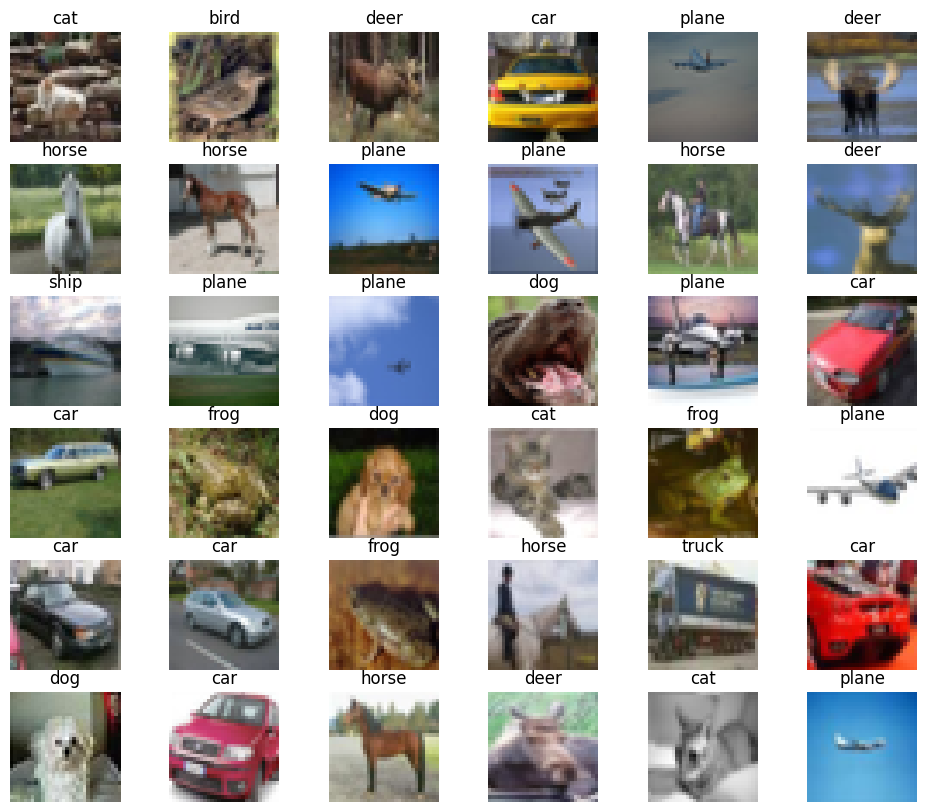

In [5]:
figure = plt.figure(figsize=(12, 10))
cols, rows = 6, 6
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(classes[label])
    plt.axis("off")
    plt.imshow(np.transpose(img, (1, 2, 0))) # width x height x rgb
plt.show()

In [6]:
# so input data is 3d tensor and label is a scalar
training_data[0][0].shape, training_data[0][1]

(torch.Size([3, 32, 32]), 6)

In [7]:
batch_size = 128
trainloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

In [8]:
len(trainloader), len(testloader)

(391, 79)

In [9]:
class VGGNet(nn.Module):
    def __init__(self, num_classes=10):
        super(VGGNet, self).__init__()
        self.features = nn.Sequential(
            # input (3, 32, 32)
            nn.Conv2d(3, 64, kernel_size=3, padding=1),  #(64, 32, 32)
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),  #(64, 32, 32)
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),        #(64, 16, 16)

            nn.Conv2d(64, 128, kernel_size=3, padding=1), #(128, 16, 16)
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),#(128, 16, 16)
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),        #(128, 8, 8)

            nn.Conv2d(128, 256, kernel_size=3, padding=1),#(256, 8, 8)
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),#(256, 8, 8)
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),#(256, 8, 8)
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),        #(256, 4, 4)

            nn.Conv2d(256, 512, kernel_size=3, padding=1),#(512, 4, 4)
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),#(512, 4, 4)
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),#(512, 4, 4)
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)         #(512, 2, 2)
        )

        self.classifier = nn.Sequential(
            nn.Linear(512 * 2 * 2, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)  # flattened
        x = self.classifier(x)
        return x

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VGGNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
epochs = 20
losses = []

In [31]:
model.train()
for epoch in range(epochs):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(trainloader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        losses.append(loss.item())
        if (i + 1) % 100 == 0:
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 100:.3f}')
            running_loss = 0.0

[1,   100] loss: 2.305
[1,   200] loss: 2.288
[1,   300] loss: 2.090
[2,   100] loss: 1.809
[2,   200] loss: 1.730
[2,   300] loss: 1.621
[3,   100] loss: 1.485
[3,   200] loss: 1.450
[3,   300] loss: 1.382
[4,   100] loss: 1.288
[4,   200] loss: 1.261
[4,   300] loss: 1.207
[5,   100] loss: 1.129
[5,   200] loss: 1.120
[5,   300] loss: 1.074
[6,   100] loss: 0.977
[6,   200] loss: 0.994
[6,   300] loss: 0.979
[7,   100] loss: 0.892
[7,   200] loss: 0.879
[7,   300] loss: 0.890
[8,   100] loss: 0.824
[8,   200] loss: 0.788
[8,   300] loss: 0.811
[9,   100] loss: 0.738
[9,   200] loss: 0.738
[9,   300] loss: 0.738
[10,   100] loss: 0.690
[10,   200] loss: 0.662
[10,   300] loss: 0.680
[11,   100] loss: 0.603
[11,   200] loss: 0.623
[11,   300] loss: 0.624
[12,   100] loss: 0.559
[12,   200] loss: 0.571
[12,   300] loss: 0.598
[13,   100] loss: 0.500
[13,   200] loss: 0.544


KeyboardInterrupt: 

In [11]:
def save_checkpoint(model, optimizer, epoch, losses, file_path='vgg_checkpoint.pth'):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'losses': losses,
    }
    torch.save(checkpoint, file_path)
    print(f'Checkpoint saved to {file_path} at epoch {epoch}')

In [13]:
checkpoint = torch.load("vgg_checkpoint3.pth")
model.load_state_dict(checkpoint["model_state_dict"])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
losses = checkpoint['losses']

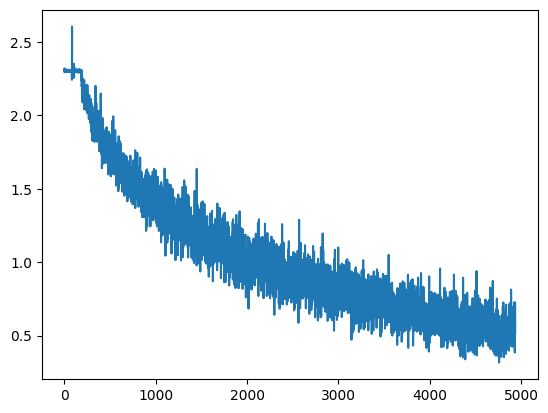

In [17]:
plt.plot(losses)

In [ ]:
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for inputs, labels in testloader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy: {100 * correct // total} %')

In [16]:
def predict(img):
    out = model(img.unsqueeze(0))
    predicted = torch.argmax(out.exp() / torch.sum(out.exp(), axis=1))
    return classes[predicted]

'truck'

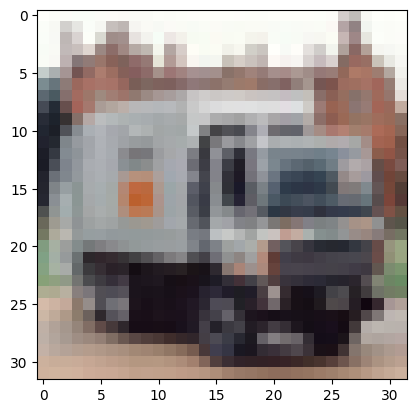

In [18]:
img = test_data[11][0]
plt.imshow(np.transpose(img, (1, 2, 0)))
predict(img)

In [80]:
def deep_dream(model, layer_name, image, iterations, lr):
    image = image.unsqueeze(0).requires_grad_()
    for _ in range(iterations):
        model.zero_grad()
        out = image
        for name, layer in model.features.named_children():
            out = layer(out)
            if name == layer_name:
                break
        loss = out.norm()
        loss.backward()
        with torch.no_grad():
            image += lr * image.grad
            image.grad.zero_()
    image = image.squeeze().clamp(0, 1).detach().numpy()
    image = np.transpose(image, (1, 2, 0))
    plt.imshow(image)

In [81]:
for name, layer in model.features.named_children():
    print(name, layer)

0 Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
1 ReLU(inplace=True)
2 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
3 ReLU(inplace=True)
4 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
5 Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
6 ReLU(inplace=True)
7 Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
8 ReLU(inplace=True)
9 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
10 Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
11 ReLU(inplace=True)
12 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
13 ReLU(inplace=True)
14 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
15 ReLU(inplace=True)
16 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
17 Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
18 ReLU(inplace=True)
19 Conv2d(512, 512, kernel_size=(3, 3)

'frog'

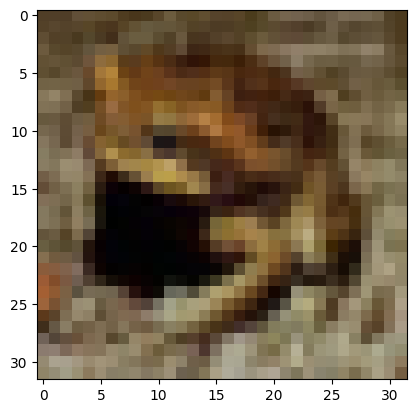

In [88]:
img = test_data[300][0]
plt.imshow(np.transpose(img, (1, 2, 0)))
predict(img)

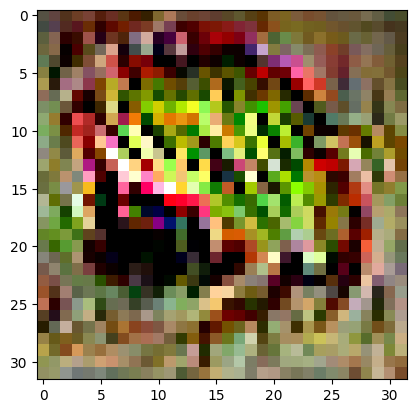

In [89]:
deep_dream(model, 21, img, 200, 0.01)